**Import modułów**

In [1]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import datasets
import seaborn as sns
import numpy as np
import matplotlib. pyplot as plt

### Wstępna analiza

In [ ]:
# Konwersja do DataFrame
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Dodanie kolumny z gatunkami
df['species'] = iris.target

# Zamiana wartości numerycznych na nazwy gatunków
df['species'] = df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Wybierz gatunek, np. 'setosa'
species_name = 'versicolor'

# Oblicz średnią szerokość płatka (petal length)
mean_petal_length = df[df['species'] == species_name]['petal width (cm)'].mean()

print(f"Średnia szerokość płatka dla {species_name}: {mean_petal_length:.2f} cm")

Średnia szerokość płatka dla versicolor: 1.33 cm


### Klasa naiwnego klasyfikatora Bayesowskiego dla cech kategorycznych

In [2]:
class MultinomialNaiveBayesClassifier:
    def __init__(self):
        self.class_log_probability = {}  # Logarytmiczne prawdopodobieństwa a priori dla każdej klasy
        self.conditional_log_probability = {}  # Logarytmiczne prawdopodobieństwa warunkowe cech względem klas
        self.epsilon = None  # Bardzo mała liczba używana zamiast zera, mala po uzyciu potegi, aby uniknąć problemów z log(0)
        self.target_column = None  # Nazwa kolumny, względem której dokonujemy predykcji

    def fit(self, X_train, column_name, epsilon):
        """
        Trenuje model na podstawie dostarczonego zbioru danych.

        Parametry:
        X_train - DataFrame zawierający dane treningowe
        column_name - nazwa kolumny z etykietami (klasami)
        epsilon - bardzo mała liczba używana zamiast zera, aby uniknąć problemów z mnożeniem zerowych prawdopodobieństw.
        
        Nie zwraca nic.
        """
        y = X_train[column_name]
        self.target_column = column_name
        self.epsilon = epsilon

        # Obliczanie logarytmicznych prawdopodobieństw a priori dla każdej klasy
        for class_label in y.unique():
            self.class_log_probability[class_label] = np.log(len(y[y == class_label]) / len(y))

        # Obliczanie logarytmicznych prawdopodobieństw warunkowych dla każdej cechy względem każdej klasy
        for column in X_train.columns:
            if column == column_name:
                continue

            self.conditional_log_probability[column] = {}
            for value in X_train[column].unique():
                self.conditional_log_probability[column][value] = {}

                for class_label in y.unique():
                    feature_count = len(y[y == class_label])
                    conditional_count = len(X_train[(y == class_label) & (X_train[column] == value)])

                    if feature_count > 0 and conditional_count > 0:
                        self.conditional_log_probability[column][value][class_label] = np.log(conditional_count / feature_count)
                    else:
                        self.conditional_log_probability[column][value][class_label] = epsilon  # Bardzo mała liczba zamiast log(0)

    def predict_with_option(self, row_to_predict, return_single):
        """
        Przewiduje klasy dla dostarczonego wiersza z opcją zwracania prawdopodobieństw.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji
        return_single - jeśli True, zwraca pojedynczą przewidywaną klasę, jeśli False zwraca prawdopodobieństwa

        Zwraca:
        Jeśli return_single=True -> przewidywana klasa (str)
        Jeśli return_single=False -> lista prawdopodobieństw dla każdej klasy
        """
        log_probability_per_class = {}

        # Obliczanie logarytmicznego prawdopodobieństwa dla każdej klasy
        for class_label in self.class_log_probability:
            log_probability = self.class_log_probability[class_label]

            for column, value in row_to_predict.items():
                if column == self.target_column:
                    continue

                if value in self.conditional_log_probability[column]:
                    log_conditional_probability = self.conditional_log_probability[column][value].get(class_label, self.epsilon)
                    log_probability += log_conditional_probability
                else:
                    log_probability += self.epsilon  # Brak warunku oznacza bardzo małe prawdopodobieństwo

            log_probability_per_class[class_label] = log_probability

        # Zwracanie wyniku w zależności od opcji return_single
        if return_single:
            return max(log_probability_per_class, key=log_probability_per_class.get)
        else:
            return {class_label: np.exp(log_prob) for class_label, log_prob in log_probability_per_class.items()}

    def predict(self, row_to_predict):
        """
        Przewiduje klasę dla pojedynczego wiersza danych.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji

        Zwraca:
        Przewidywana klasa (str)
        """
        return self.predict_with_option(row_to_predict, True)

    def predict_proba(self, row_to_predict):
        """
        Zwraca prawdopodobieństwa dla każdej klasy dla pojedynczego wiersza danych.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji

        Zwraca:
        Słownik prawdopodobieństw dla każdej klasy
        """
        return self.predict_with_option(row_to_predict, False)

### Klasa naiwnego klasyfikatora Bayesowskiego dla cech ilościowych

In [3]:
class GaussianNaiveBayesClassifier:
    def __init__(self):
        self.class_log_probability = {}  # Logarytmiczne prawdopodobieństwa a priori dla każdej klasy
        self.gaussian_parameters = {}  # Średnie i odchylenia standardowe cech względem klas
        self.target_column = None  # Nazwa kolumny z etykietami klas
        self.epsilon = None  # Bardzo mała liczba, aby uniknąć log(0)

    def fit(self, X_train, column_name, epsilon):
        """
        Trenuje model Gaussowskiego Naive Bayes na podstawie danych treningowych.

        Parametry:
        X_train - DataFrame zawierający dane treningowe
        column_name - nazwa kolumny z etykietami (klasami)
        epsilon - bardzo mała liczba używana zamiast zera, aby uniknąć problemów z logarytmowaniem zerowych prawdopodobieństw

        Nie zwraca nic.
        """
        y = X_train[column_name]
        self.target_column = column_name
        self.epsilon = epsilon

        # Obliczanie logarytmicznych prawdopodobieństw a priori dla każdej klasy
        for class_label in y.unique():
            self.class_log_probability[class_label] = np.log(len(y[y == class_label]) / len(y))

        # Obliczanie średnich i odchyleń standardowych dla każdej cechy względem każdej klasy
        for class_label in y.unique():
            class_data = X_train[X_train[column_name] == class_label]
            feature_mean = class_data.mean()
            feature_std = class_data.std()
            self.gaussian_parameters[class_label] = {}

            for column in X_train.columns:
                if column == column_name:
                    continue
                self.gaussian_parameters[class_label][column] = (feature_mean[column], feature_std[column])

    @staticmethod
    def log_gaussian_density(x, mean, std):
        """
        Oblicza logarytm funkcji Gaussa (gęstości rozkładu normalnego) dla danej wartości x.

        Parametry:
        x    - wartość, dla której obliczamy funkcję gęstości
        mean - średnia rozkładu
        std  - odchylenie standardowe rozkładu

        Zwraca:
        Logarytm wartości funkcji Gaussa dla zadanych parametrów.
        """
        eps = 1e-9  # Mała wartość, aby uniknąć dzielenia przez zero
        coeff = -0.5 * np.log(2.0 * np.pi * (std**2 + eps))
        exponent = -((x - mean)**2) / (2.0 * (std**2 + eps))
        return coeff + exponent

    def predict_with_option(self, row_to_predict, return_single):
        """
        Przewiduje klasy dla dostarczonego wiersza z opcją zwracania prawdopodobieństw.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji
        return_single - jeśli True, zwraca pojedynczą przewidywaną klasę, jeśli False zwraca prawdopodobieństwa

        Zwraca:
        Jeśli return_single=True -> przewidywana klasa (str)
        Jeśli return_single=False -> lista prawdopodobieństw dla każdej klasy
        """
        log_probability_per_class = {}

        # Obliczanie logarytmicznego prawdopodobieństwa dla każdej klasy
        for class_label in self.class_log_probability:
            log_probability = self.class_log_probability[class_label]

            for column, value in row_to_predict.items():
                if column == self.target_column:
                    continue

                if column in self.gaussian_parameters[class_label]:
                    mean, std = self.gaussian_parameters[class_label][column]
                    log_probability += self.log_gaussian_density(value, mean, std)
                else:
                    log_probability += self.epsilon  # Brak warunku oznacza bardzo małe prawdopodobieństwo

            log_probability_per_class[class_label] = log_probability

        # Zwracanie wyniku w zależności od opcji return_single
        if return_single:
            return max(log_probability_per_class, key=log_probability_per_class.get)
        else:
            return {class_label: np.exp(log_prob) for class_label, log_prob in log_probability_per_class.items()}

    def predict(self, row_to_predict):
        """
        Przewiduje klasę dla pojedynczego wiersza danych.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji

        Zwraca:
        Przewidywana klasa (str)
        """
        return self.predict_with_option(row_to_predict, True)

    def predict_proba(self, row_to_predict):
        """
        Zwraca prawdopodobieństwa dla każdej klasy dla pojedynczego wiersza danych.

        Parametry:
        row_to_predict - Series zawierający dane wejściowe do predykcji

        Zwraca:
        Słownik prawdopodobieństw dla każdej klasy
        """
        return self.predict_with_option(row_to_predict, False)

### Ocena modelu

**Funkcje używane do oceny dokładności modelów**

In [7]:
# testuje model na zadanych parametrach, i zwraca te tablice - jedna poprawnego wyniku, a druga przewidywanego
def test_model(_model: MultinomialNaiveBayesClassifier | GaussianNaiveBayesClassifier,
                     _set: pd.DataFrame, 
                     _target_column, 
                     _test_size: float=0.2, 
                     _epsilon=1e-6, 
                     _seed: int = None
        ) -> tuple[np.array, np.array]:
    
    # Podział na zbiory treningowy i testowy
    X_train, X_test = train_test_split(_set, test_size=_test_size, random_state=_seed)

    # trenujemy model
    classifier = _model()
    classifier.fit(X_train, column_name=_target_column, epsilon=_epsilon)

    #obliczanie dokladnosci
    total_samples = len(X_test)

    predicted = []
    correct = []

    for i in range(total_samples):
        predicted.append(classifier.predict(X_test.iloc[i]))
        correct.append(X_test[_target_column].iloc[i])

    return np.array(correct), np.array(predicted)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def print_report(correct: np.array, predict: np.array, set_name = "") -> None:
    print(f"Ocena klasyfikatora dla zbioru {set_name}:")
    print(f"Accuracy: {accuracy_score(correct, predict):.4f}")
    print("Classification Report:")
    print(classification_report(correct, predict))
    print("Confusion Matrix:")
    print(confusion_matrix(correct, predict))

**Analiza Mushrooms**

In [61]:
file_path = "./mushroom-classification/mushrooms.csv"

mushrooms = pd.read_csv(file_path)
target_column = 'class'
model = MultinomialNaiveBayesClassifier

y_test_mush, y_pred_mush = test_model(_model=model, 
                                      _target_column=target_column, 
                                      _set=mushrooms, 
                                      _test_size=0.3)

print_report(y_test_mush, y_pred_mush, "Mushrooms")

Ocena klasyfikatora dla zbioru Mushrooms:
Accuracy: 0.8392
Classification Report:
              precision    recall  f1-score   support

           e       0.81      0.90      0.85      1277
           p       0.87      0.77      0.82      1161

    accuracy                           0.84      2438
   macro avg       0.84      0.84      0.84      2438
weighted avg       0.84      0.84      0.84      2438

Confusion Matrix:
[[1147  130]
 [ 262  899]]


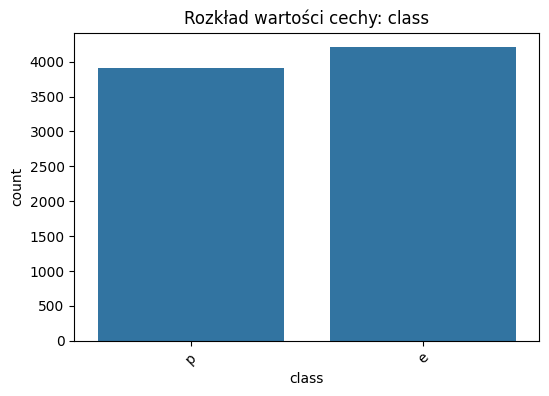

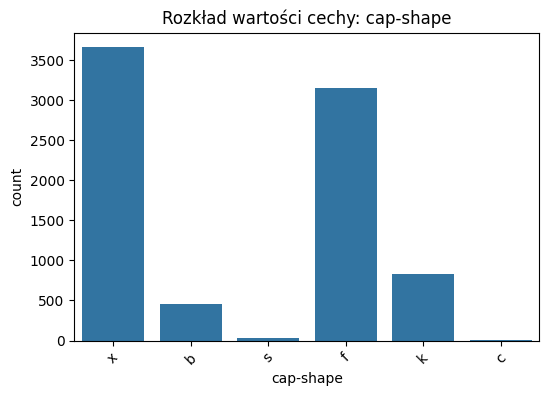

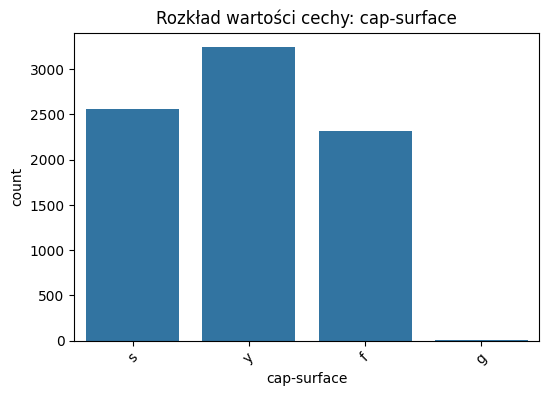

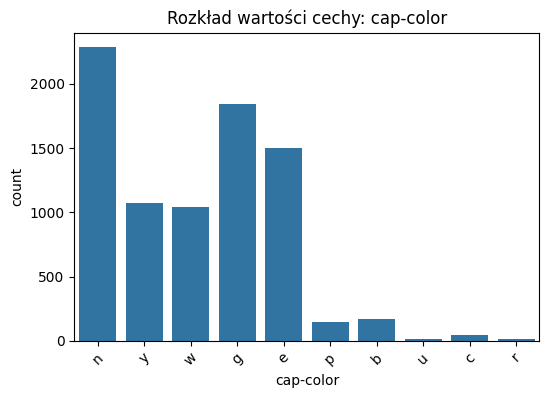

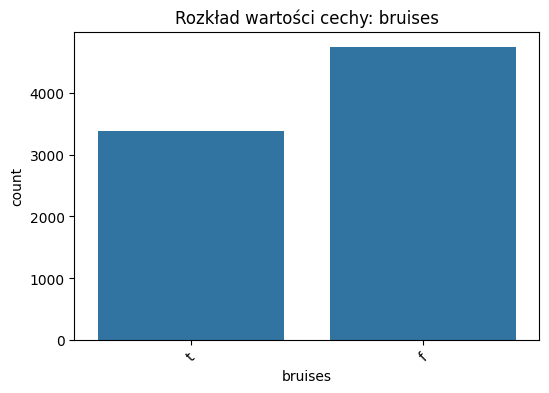

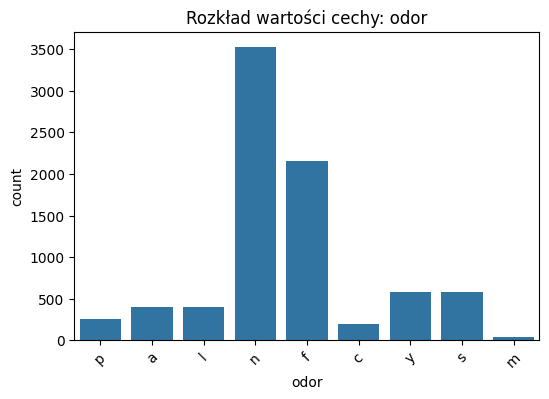

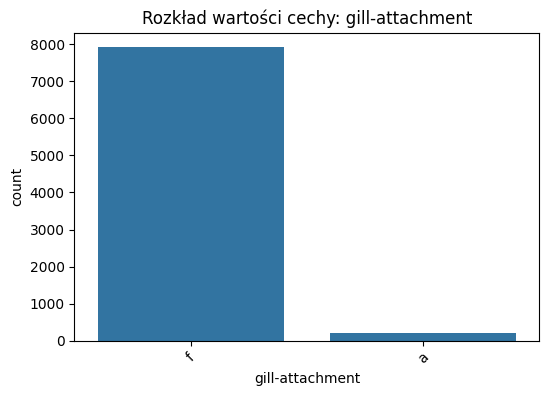

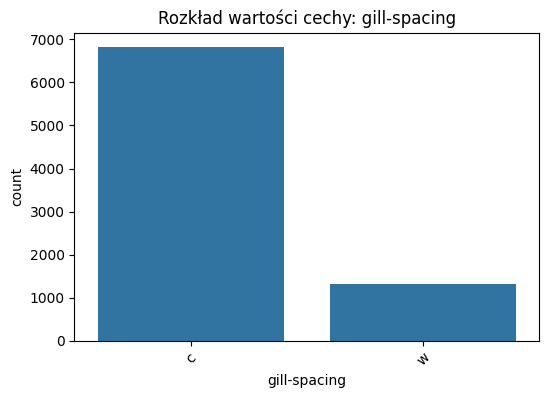

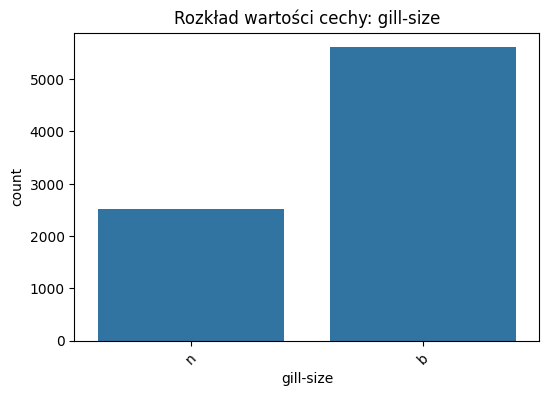

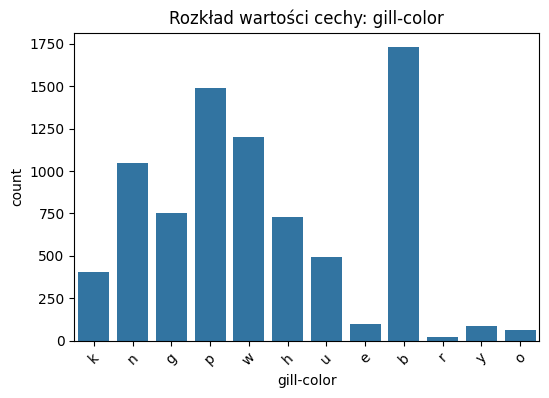

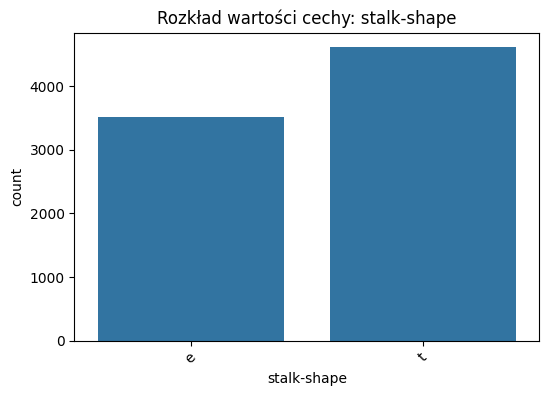

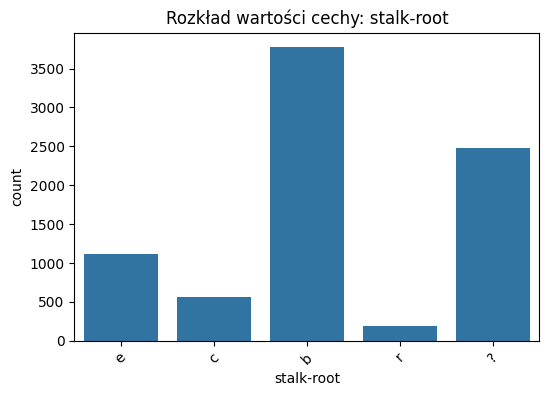

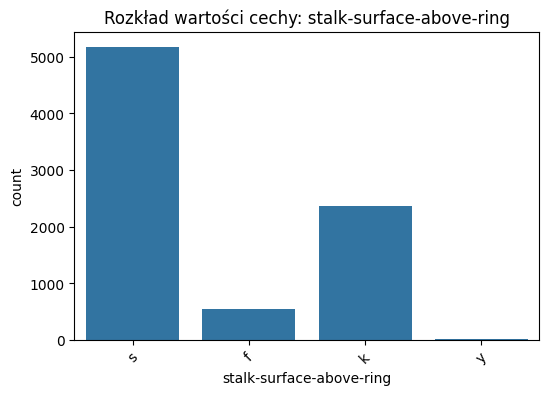

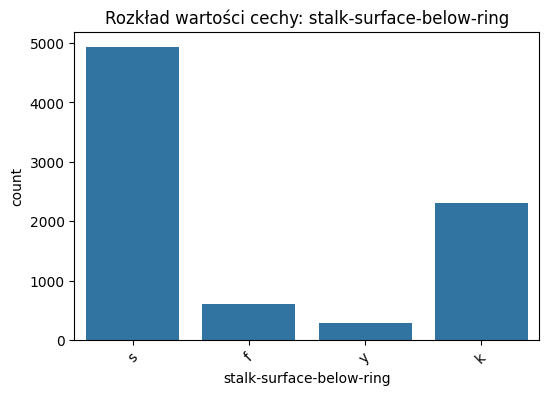

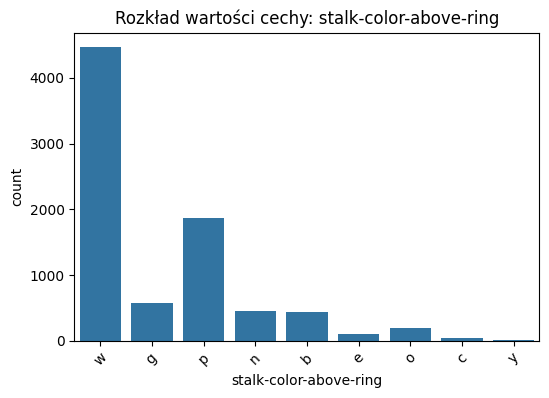

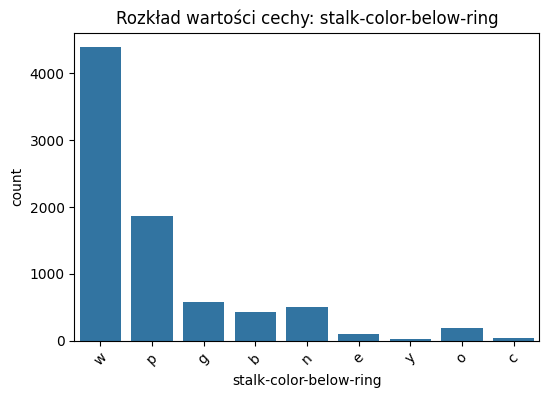

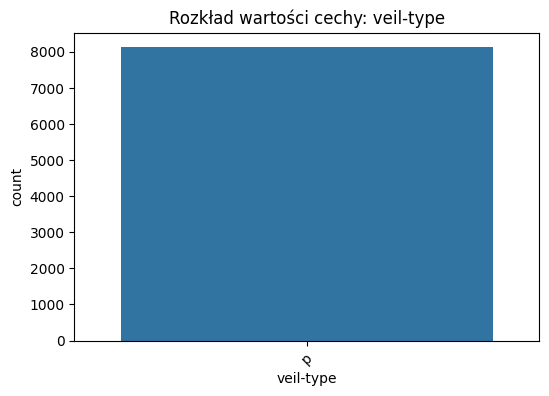

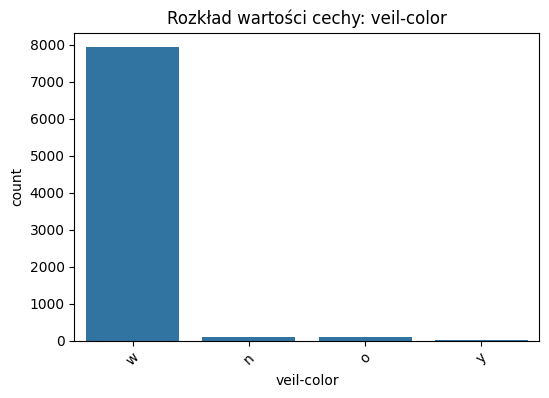

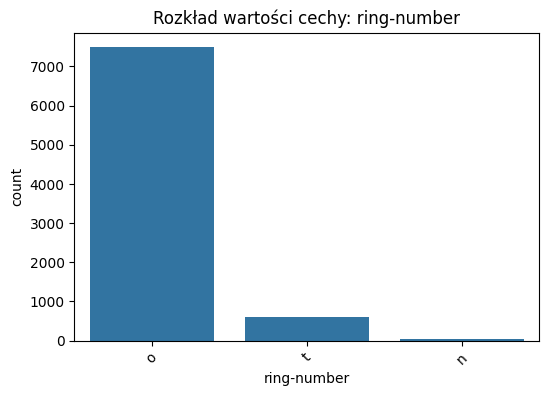

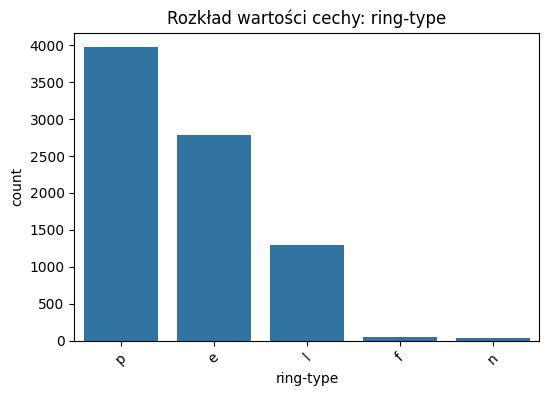

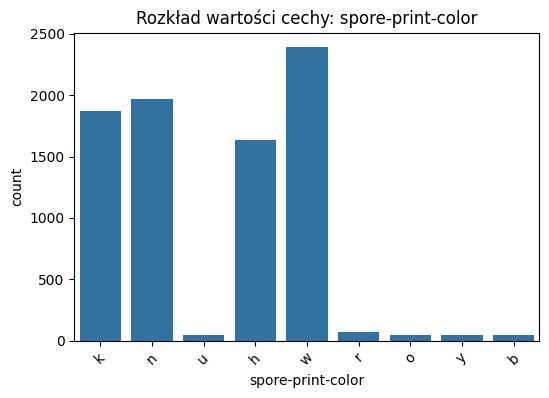

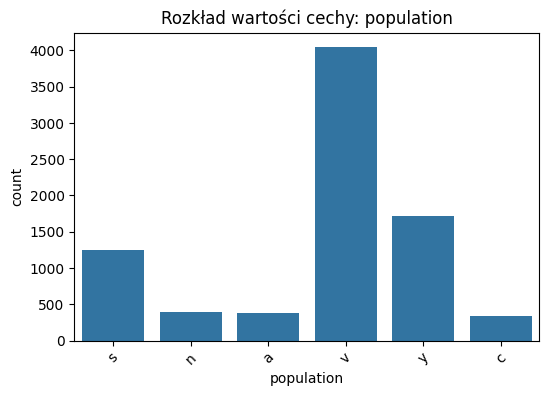

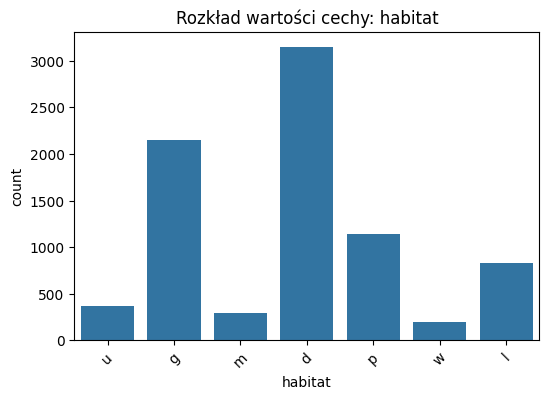

In [51]:
for col in mushrooms.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=mushrooms[col])
    plt.title(f"Rozkład wartości cechy: {col}")
    plt.xticks(rotation=45)
    plt.show()


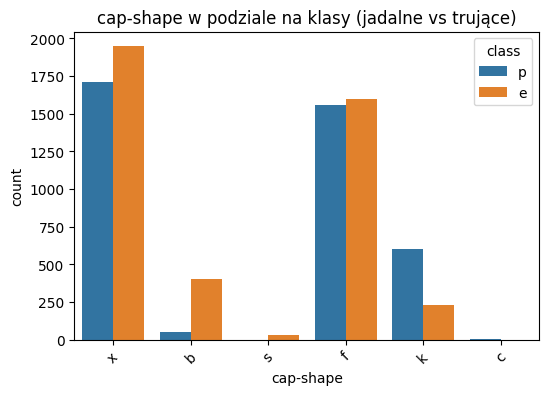

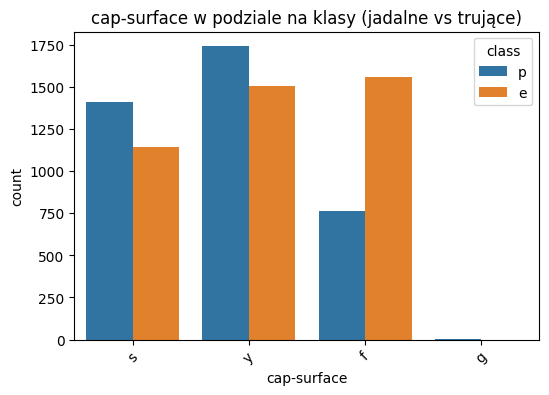

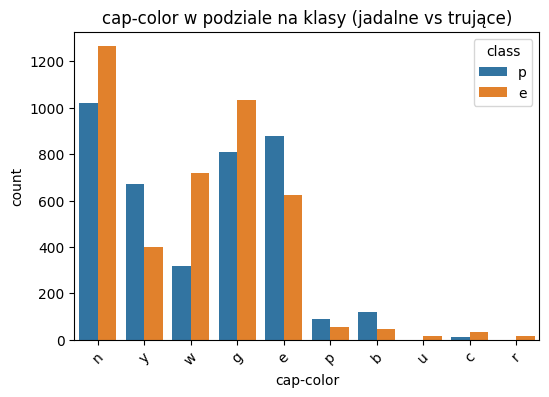

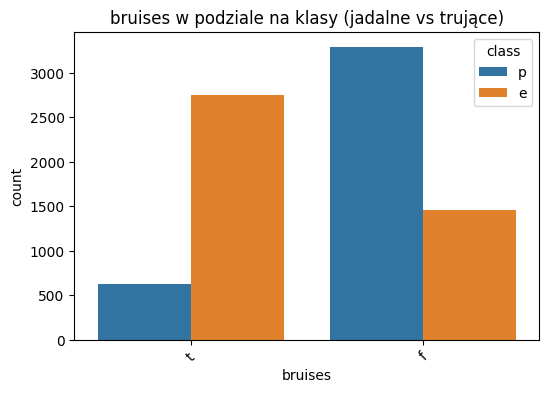

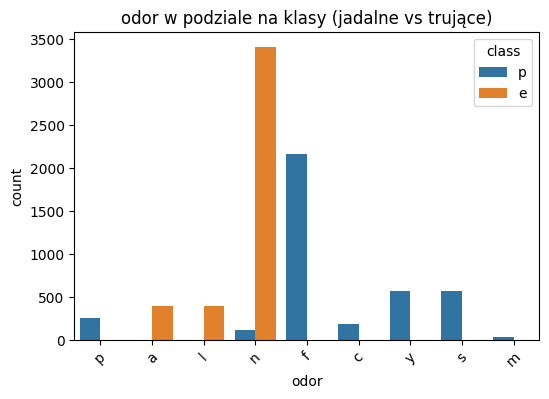

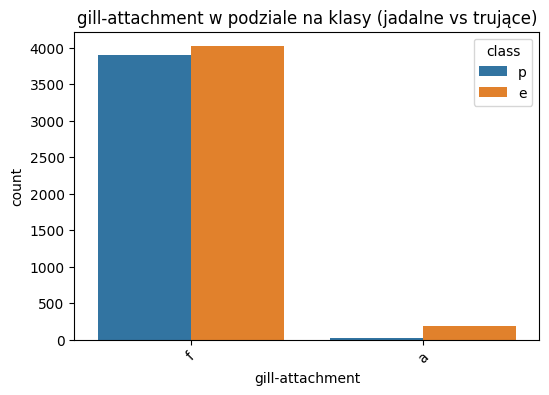

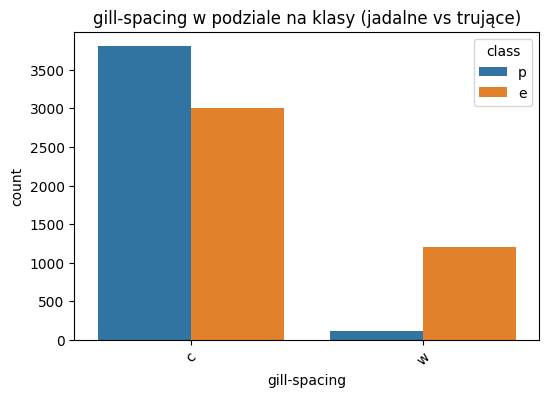

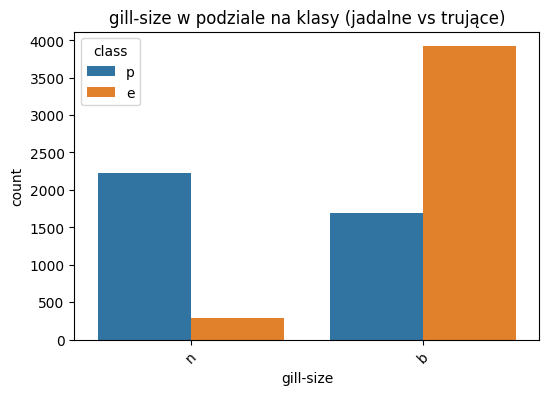

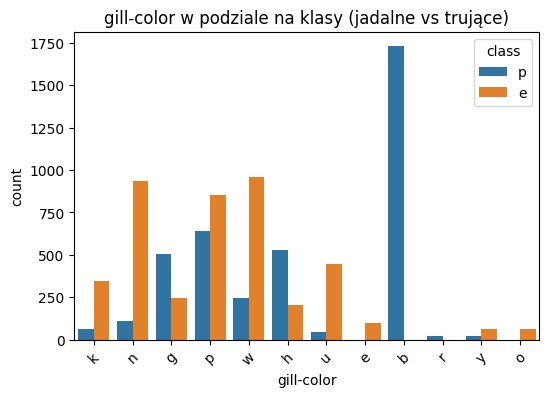

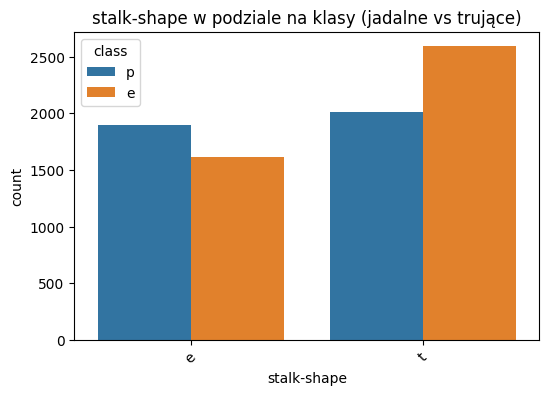

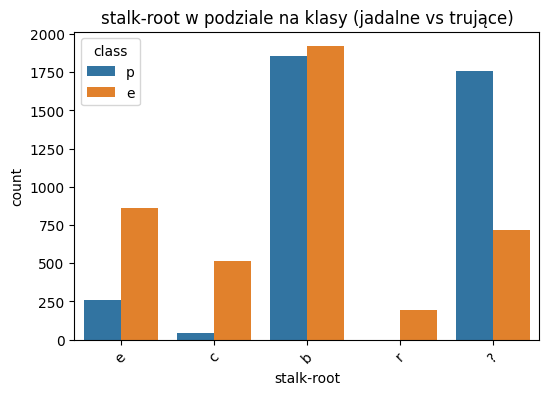

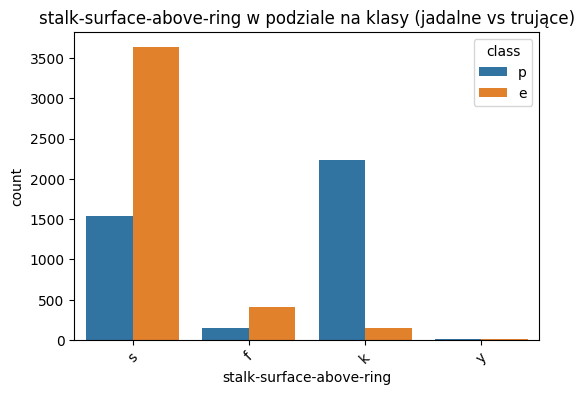

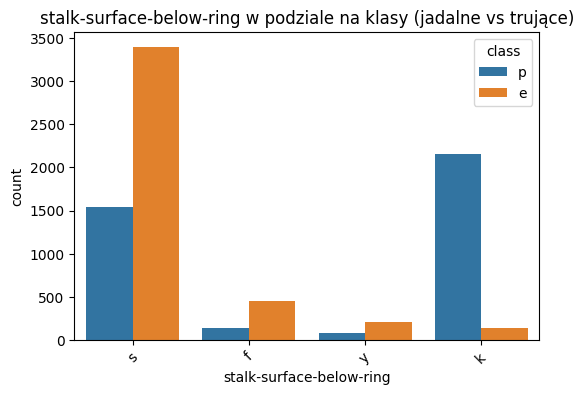

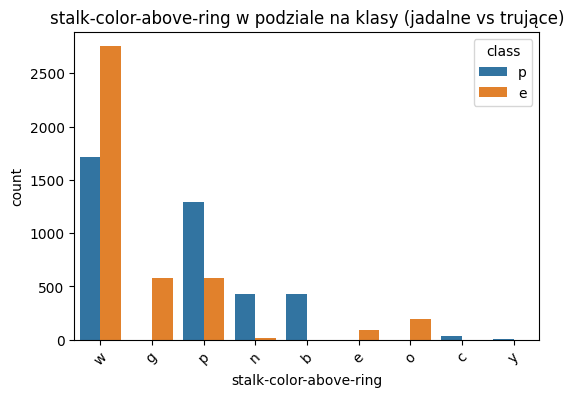

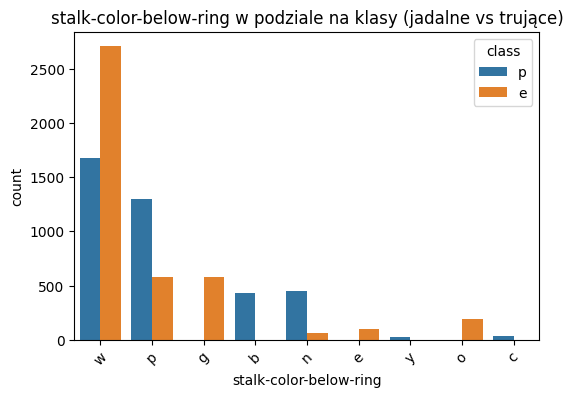

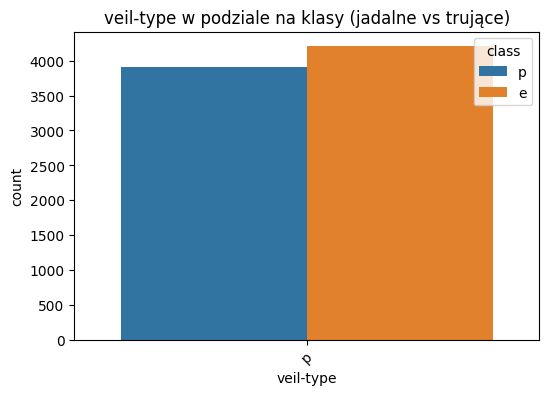

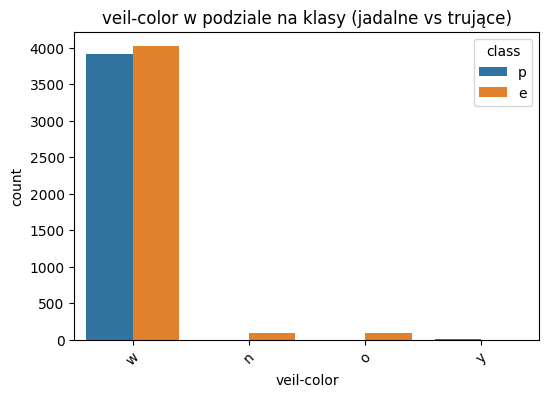

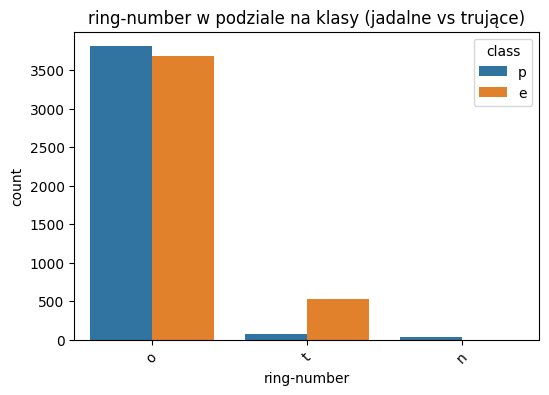

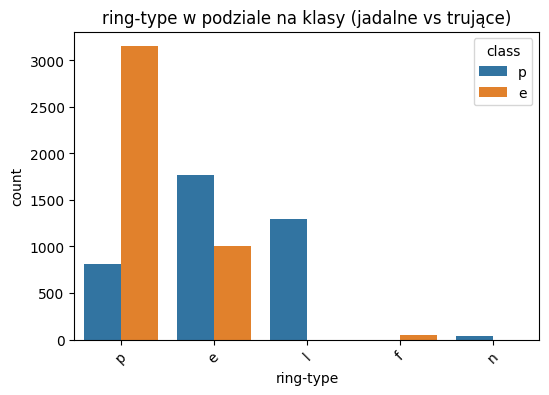

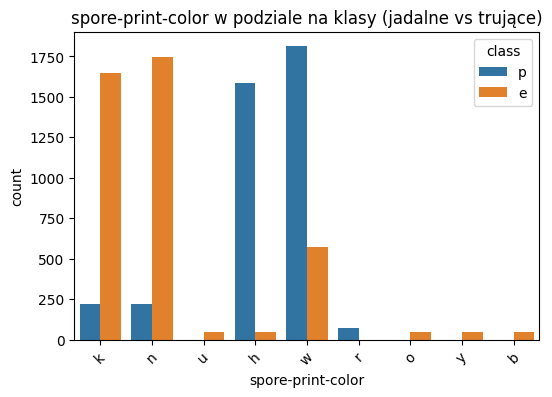

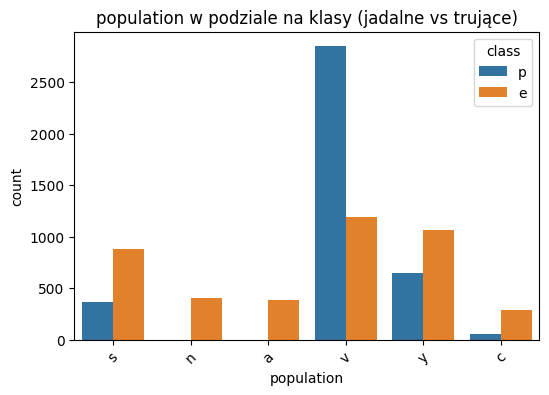

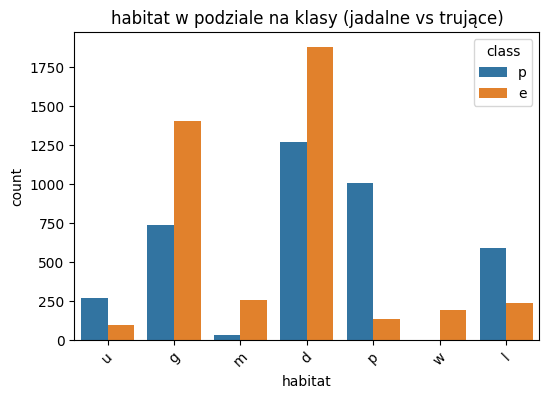

In [53]:
for col in mushrooms.columns[1:]:  # Pomijamy "class"
    plt.figure(figsize=(6, 4))
    sns.countplot(x=mushrooms[col], hue=mushrooms["class"])
    plt.title(f"{col} w podziale na klasy (jadalne vs trujące)")
    plt.xticks(rotation=45)
    plt.show()


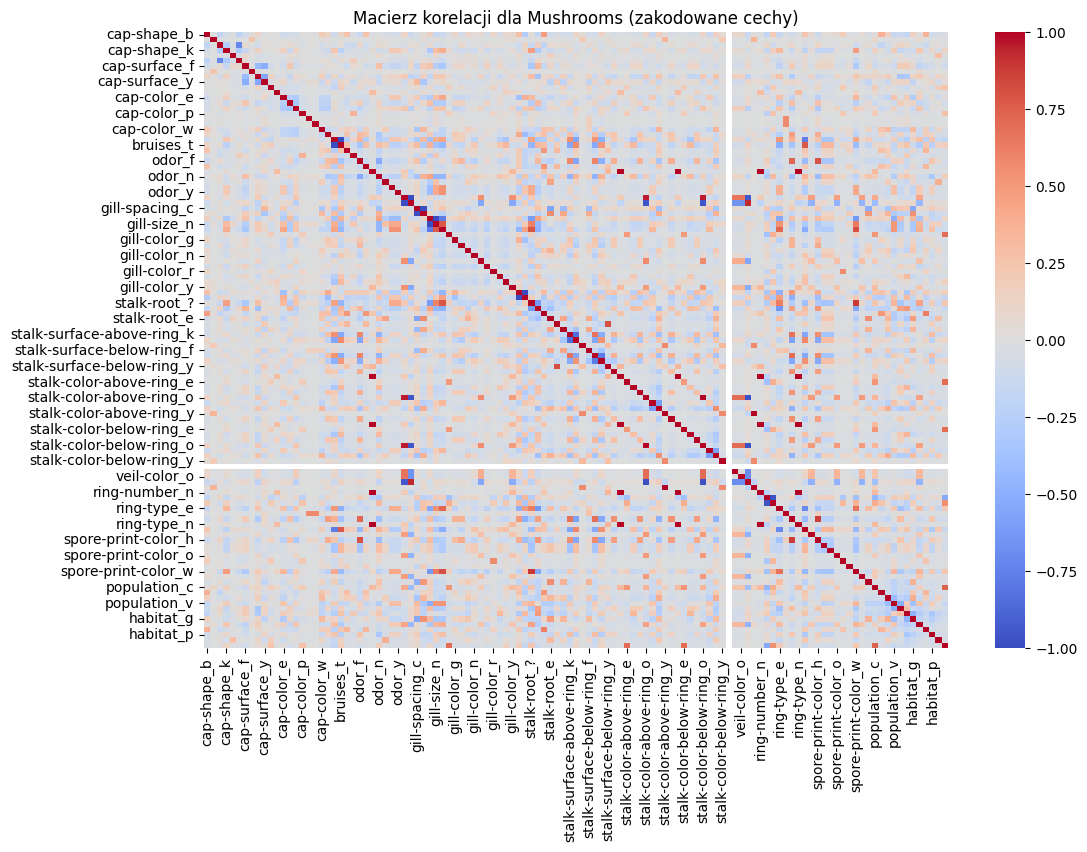

In [52]:
mush_encoded = pd.get_dummies(mushrooms.drop(columns=["class"]))
plt.figure(figsize=(12,8))
sns.heatmap(mush_encoded.corr(), cmap="coolwarm")
plt.title("Macierz korelacji dla Mushrooms")
plt.show()


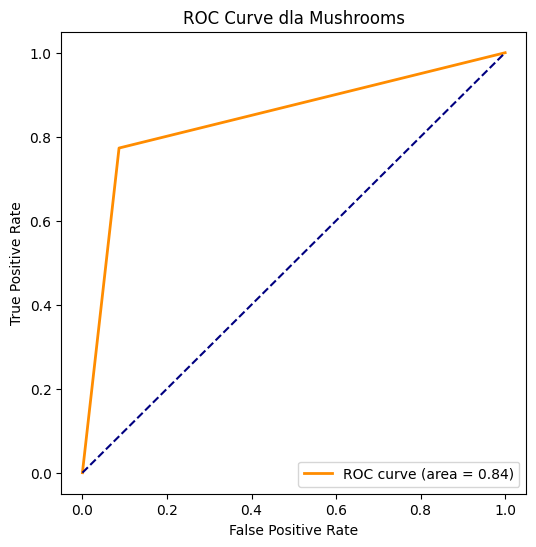

In [49]:
from sklearn.metrics import roc_curve, auc

file_path = "./mushroom-classification/mushrooms.csv"

mushrooms = pd.read_csv(file_path)
target_column = 'class'
model = MultinomialNaiveBayesClassifier

y_test_mush, y_pred_mush = test_model(_model=model, 
                                      _target_column=target_column, 
                                      _set=mushrooms, 
                                      _test_size=0.2)

# preparing data: e -> 0, p -> 1
y_test_mush[y_test_mush == 'e'] = 0
y_test_mush[y_test_mush == 'p'] = 1
y_pred_mush[y_pred_mush == 'e'] = 0
y_pred_mush[y_pred_mush == 'p'] = 1
y_test_mush = y_test_mush.astype('int') 
y_pred_mush = y_pred_mush.astype('int') 

fpr, tpr, _ = roc_curve(y_test_mush, y_pred_mush)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve dla Mushrooms")
plt.legend(loc="lower right")
plt.show()


**Analiza Iris**

In [253]:
import pandas as pd

iris = load_iris()

target_column = 'species'
model = GaussianNaiveBayesClassifier
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df[target_column] = iris.target  # Dodajemy kolumnę z etykietami klas

y_test_iris, y_pred_iris = test_model(_model=model, 
                                      _target_column=target_column, 
                                      _set=iris_df, 
                                      _test_size=0.3)

print_report(y_test_iris, y_pred_iris, "Iris")

Ocena klasyfikatora dla zbioru Iris:
Accuracy: 0.9556
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      0.88      0.93        16
           2       0.85      1.00      0.92        11

    accuracy                           0.96        45
   macro avg       0.95      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45

Confusion Matrix:
[[18  0  0]
 [ 0 14  2]
 [ 0  0 11]]


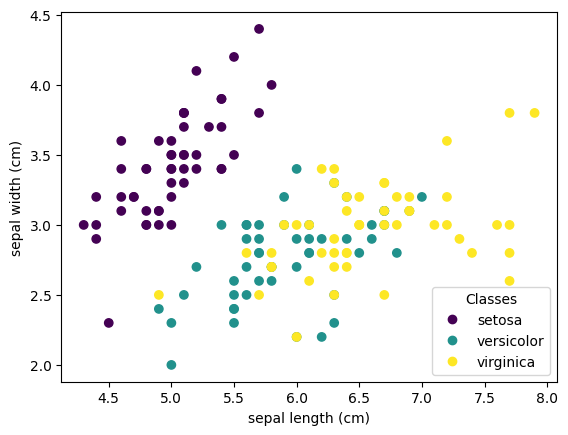

In [260]:
iris = datasets.load_iris()

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

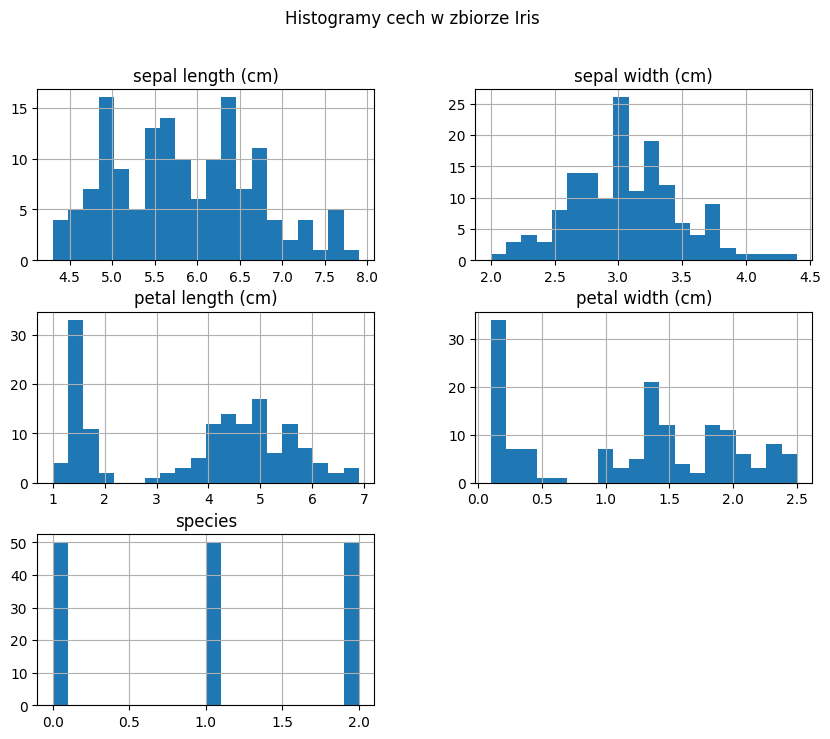

In [258]:
model = GaussianNaiveBayesClassifier
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df[target_column] = iris.target  # Dodajemy kolumnę z etykietami klas

iris_df.hist(figsize=(10, 8), bins=20)
plt.suptitle("Histogramy cech w zbiorze Iris")
plt.show()

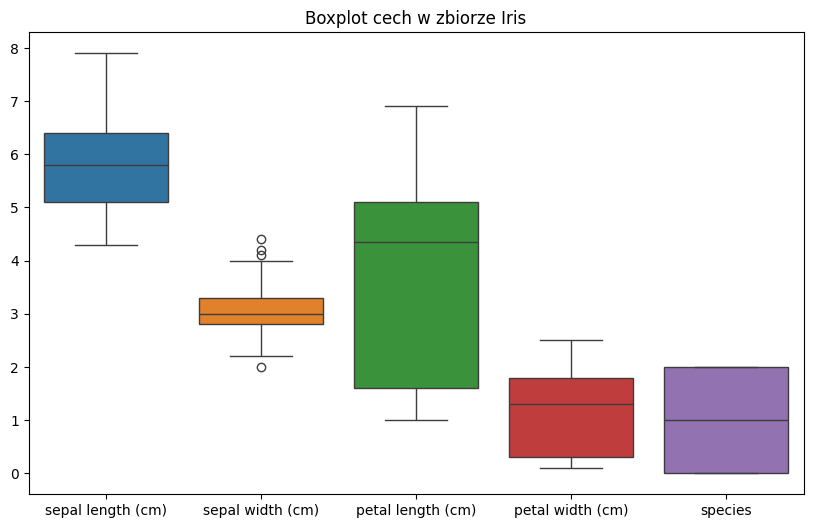

In [256]:
plt.figure(figsize=(10,6))
sns.boxplot(data=iris_df)
plt.title("Boxplot cech w zbiorze Iris")
plt.show()


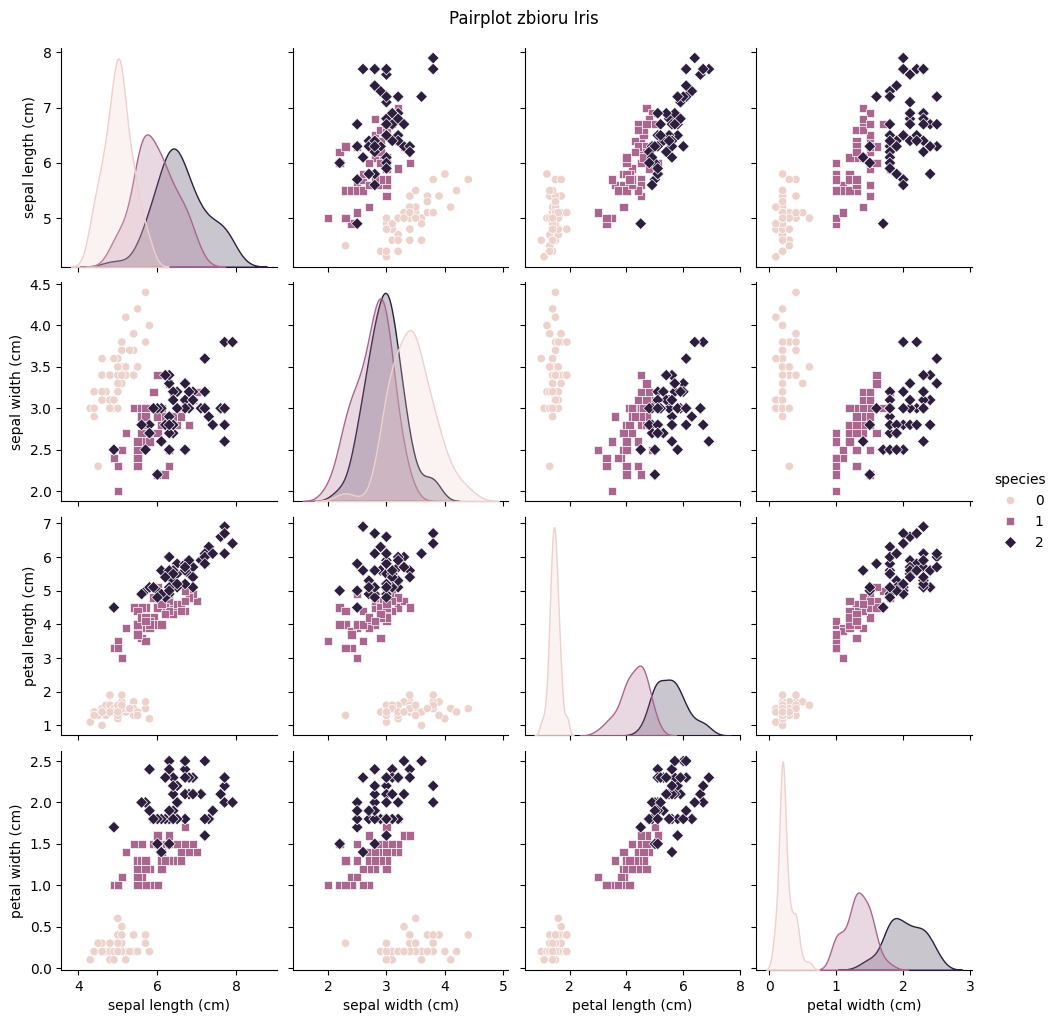

In [257]:
sns.pairplot(iris_df, hue="species", markers=["o", "s", "D"])
plt.suptitle("Pairplot zbioru Iris", y=1.02)
plt.show()


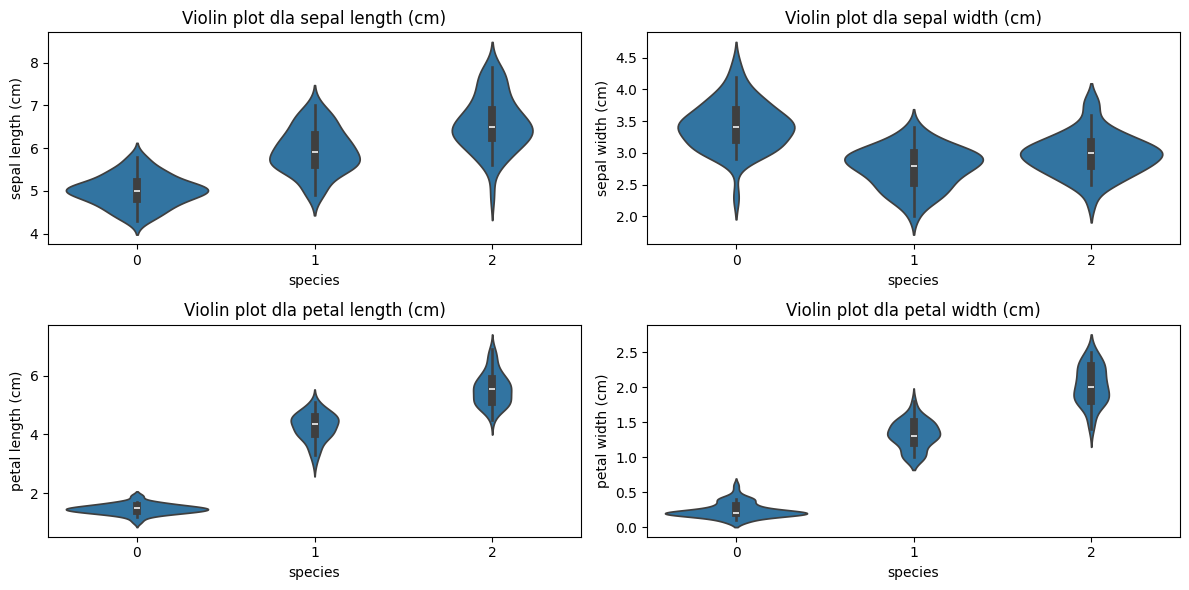

In [259]:
plt.figure(figsize=(12,6))
for i, col in enumerate(iris_df.columns[:-1]):  # Wszystkie cechy numeryczne
    plt.subplot(2,2,i+1)
    sns.violinplot(x=iris_df["species"], y=iris_df[col])
    plt.title(f"Violin plot dla {col}")
plt.tight_layout()
plt.show()
